In [64]:
#from google.colab import drive
#drive.mount('/gdrive')
%cd /home/luis/PycharmProjects/an2dl_challenge_1

/home/luis/PycharmProjects/an2dl_challenge_1


In [65]:
!rm -rf models.py
!rm -rf visualization.py
!rm -rf data_preparation.py
#files.upload()

(4052, 96, 96, 3)
(451, 96, 96, 3)
(501, 96, 96, 3)
(array([0., 1.], dtype=float32), array([4052, 4052]))
(array([0., 1.], dtype=float32), array([451, 451]))


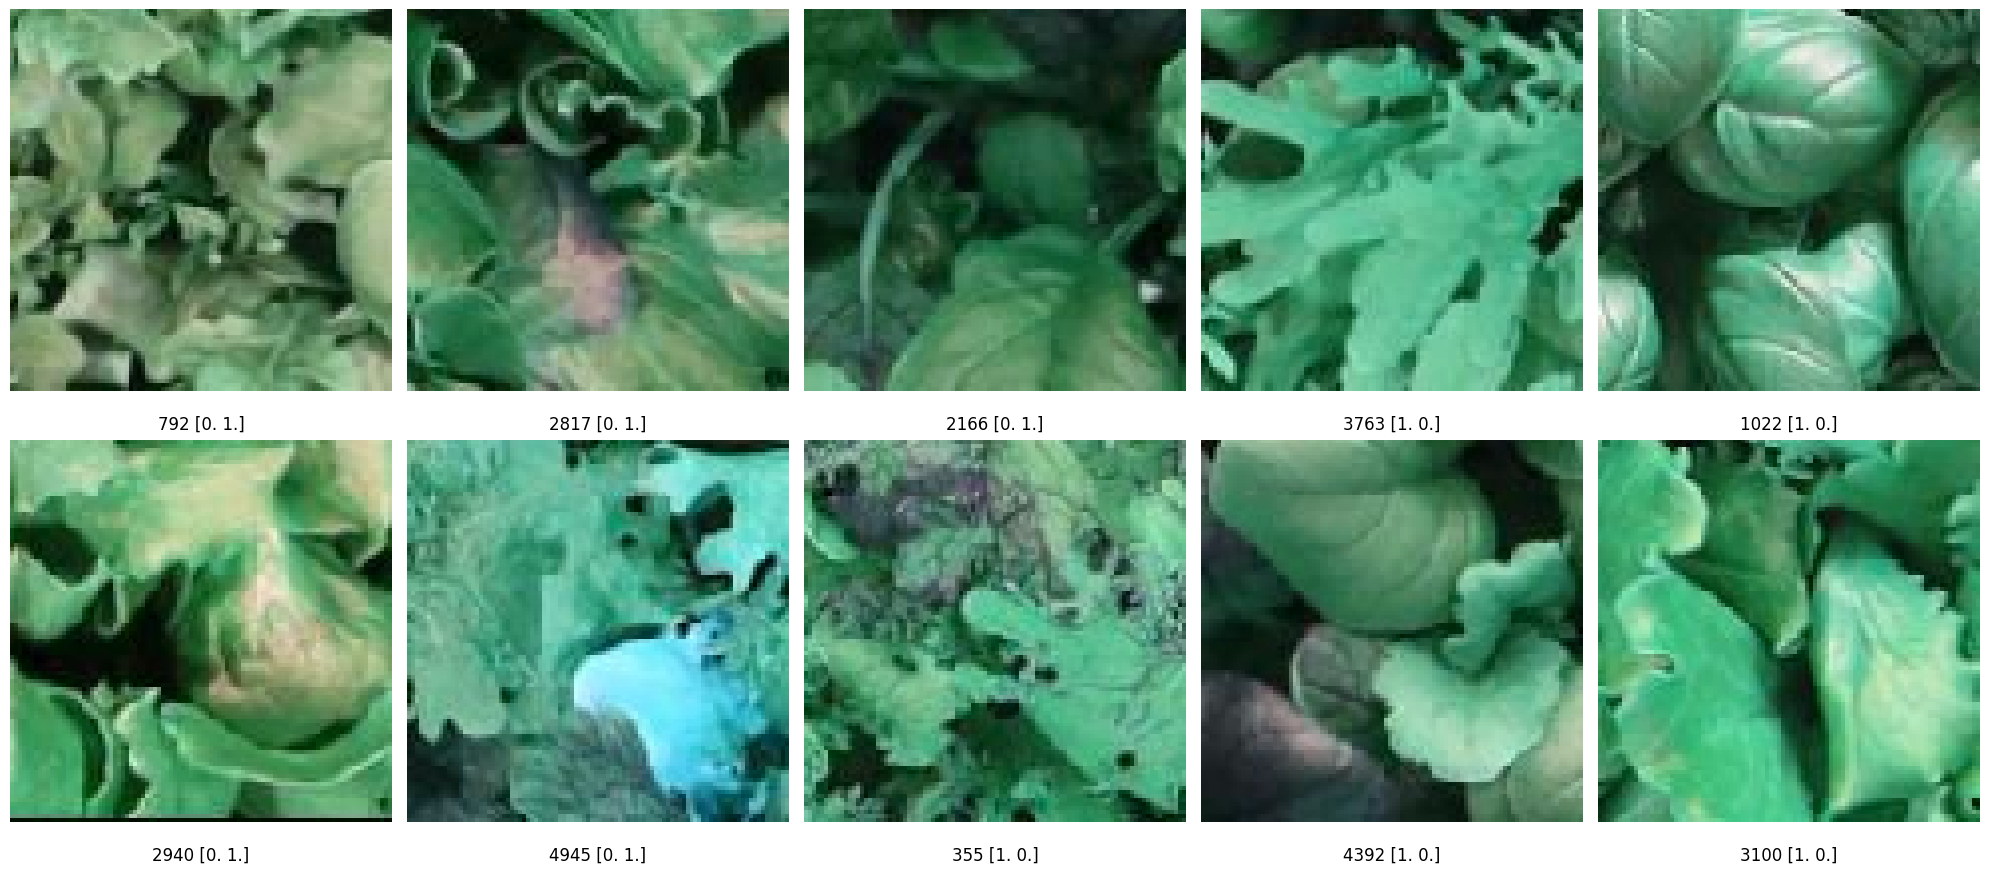

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from data_preparation import load_data, delete_outliers
from data_preparation import display_random_images
import numpy as np
from visualization import plot_history


X, y = load_data('/home/luis/PycharmProjects/an2dl_challenge_1/an2dl_challenge_1/public_data.npz')

X, y, num_outliers = delete_outliers(X, y)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=np.argmax(y_train_val,axis=1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))


display_random_images(X, y, num_img=10)

In [67]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [68]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [69]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [70]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [71]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
254/254 [==============================] - 8s 28ms/step - loss: 0.5282 - accuracy: 0.7473 - val_loss: 0.4195 - val_accuracy: 0.8071
Epoch 2/100
254/254 [==============================] - 6s 25ms/step - loss: 0.4221 - accuracy: 0.8065 - val_loss: 0.3999 - val_accuracy: 0.8359
Epoch 3/100
254/254 [==============================] - 6s 25ms/step - loss: 0.3837 - accuracy: 0.8307 - val_loss: 0.4076 - val_accuracy: 0.8182
Epoch 4/100
254/254 [==============================] - 6s 25ms/step - loss: 0.3597 - accuracy: 0.8401 - val_loss: 0.3715 - val_accuracy: 0.8359
Epoch 5/100
254/254 [==============================] - 6s 25ms/step - loss: 0.3347 - accuracy: 0.8554 - val_loss: 0.4381 - val_accuracy: 0.7894
Epoch 6/100
254/254 [==============================] - 6s 25ms/step - loss: 0.3306 - accuracy: 0.8591 - val_loss: 0.3809 - val_accuracy: 0.8271
Epoch 7/100
254/254 [==============================] - 6s 26ms/step - loss: 0.3201 - accuracy: 0.8648 - val_loss: 0.4057 - val_accuracy:

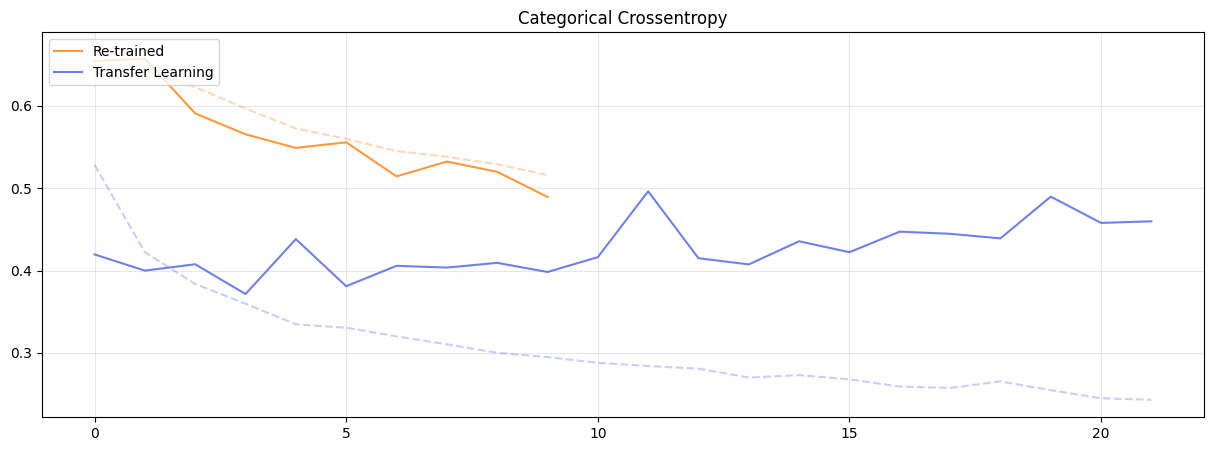

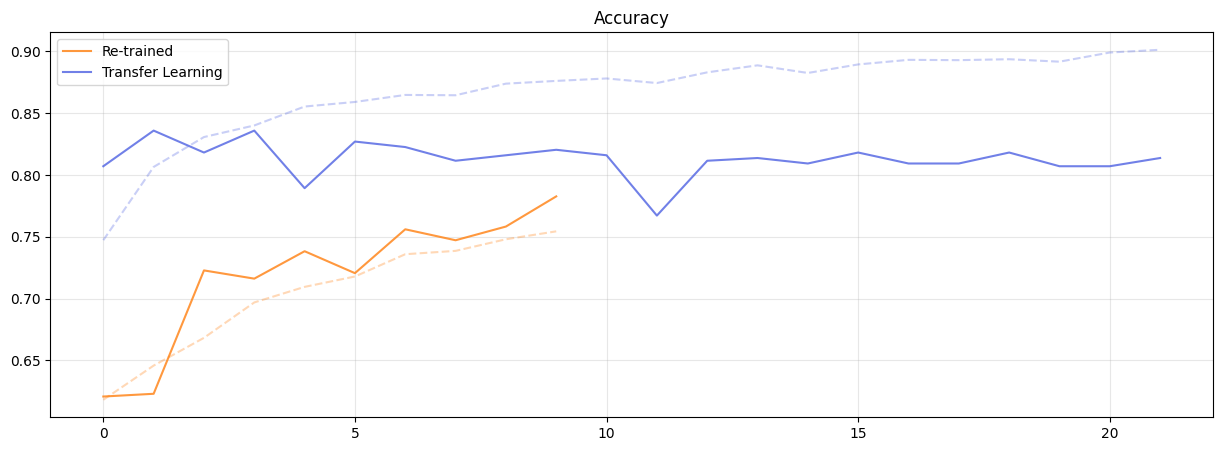

In [72]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [73]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

INFO:tensorflow:Assets written to: TransferLearningModel/assets


INFO:tensorflow:Assets written to: TransferLearningModel/assets


In [74]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [75]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_21 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tr

In [76]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_21 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_exp

Total params: 2260546 (8.62 MB)
Trainable params: 1208642 (4.61 MB)
Non-trainable params: 1051904 (4.01 MB)
_________________________________________________________________


In [77]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [78]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
254/254 [==============================] - 10s 32ms/step - loss: 0.5372 - accuracy: 0.7485 - val_loss: 0.4266 - val_accuracy: 0.8337
Epoch 2/100
254/254 [==============================] - 8s 33ms/step - loss: 0.4579 - accuracy: 0.7954 - val_loss: 0.4145 - val_accuracy: 0.8204
Epoch 3/100
254/254 [==============================] - 8s 32ms/step - loss: 0.4041 - accuracy: 0.8287 - val_loss: 0.3945 - val_accuracy: 0.8204
Epoch 4/100
254/254 [==============================] - 8s 33ms/step - loss: 0.3819 - accuracy: 0.8346 - val_loss: 0.3812 - val_accuracy: 0.8404
Epoch 5/100
254/254 [==============================] - 8s 32ms/step - loss: 0.3522 - accuracy: 0.8541 - val_loss: 0.3721 - val_accuracy: 0.8448
Epoch 6/100
254/254 [==============================] - 8s 33ms/step - loss: 0.3207 - accuracy: 0.8744 - val_loss: 0.3628 - val_accuracy: 0.8559
Epoch 7/100
254/254 [==============================] - 8s 33ms/step - loss: 0.3052 - accuracy: 0.8847 - val_loss: 0.3554 - val_accuracy

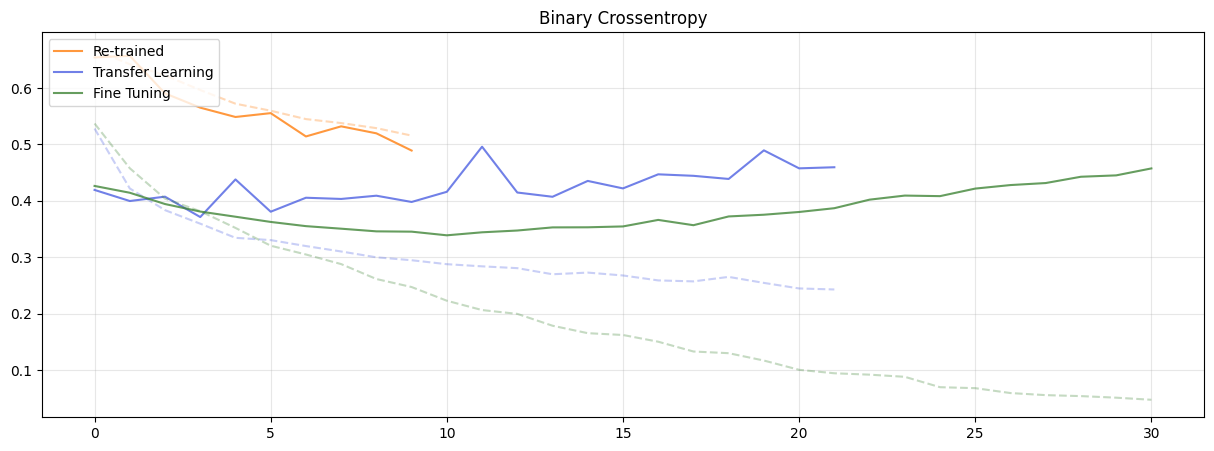

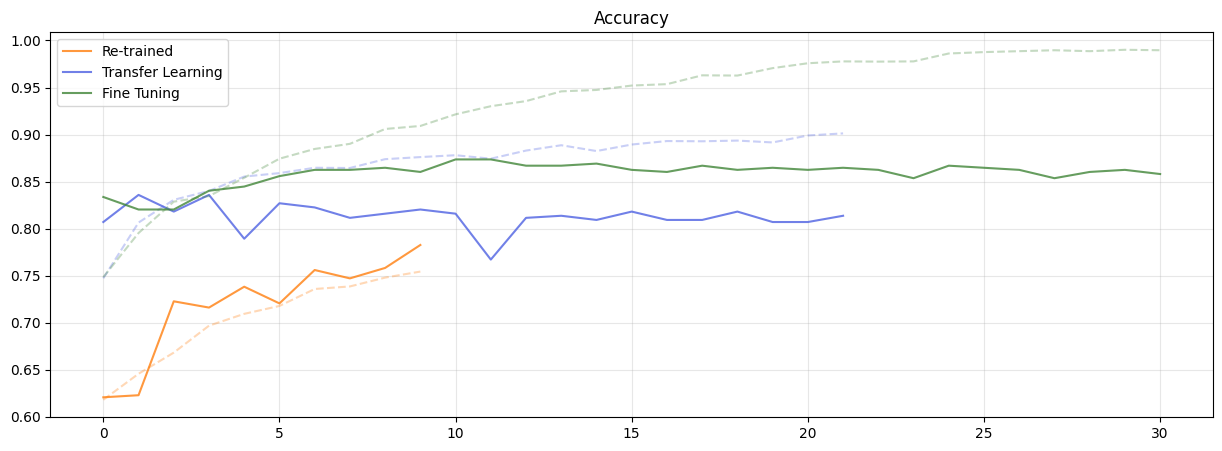

In [79]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [80]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8283
